In [29]:
import csv
import numpy as np
import matplotlib.pyplot as plt
import re

series = {str: {}, float: {}}
names = {}

num_processed = 0

with open('work/simlog.csv', 'rt') as f:
    reader = csv.reader(f, delimiter=',')
    next(reader)

    for time_str, target, value in reader:
        if time_str == 'DEF':
            names[target] = value
            continue
        
        time = float(time_str)

        if target in series[str]:
            series[str][target][0].append(time)
            series[str][target][1].append(value)
        elif target in series[float]:
            series[float][target][0].append(time)
            series[float][target][1].append(float(value))
        else:
            try:
                value_float = float(value)
                series[float][target] = ([time], [value_float])
            except:
                series[str][target] = ([time], [value])

        num_processed += 1

print(f'Processed {num_processed} entries for {len(names)} targets.')

Processed 13241 entries for 9 targets.


StationToStationAgent/0/implFeed:
    0.200: Set goal: station CERN Meyrin, 70 m away, ETA 16:26:19
   25.800: Plan exhausted
   25.800: Approaching CERN Meyrin, stopping. Next station will be Ferney-Voltaire, 5485 meters.
   36.800: Set goal: station Ferney-Voltaire, 5485 m away, ETA 16:31:00
  271.800: Plan exhausted
  272.000: Set goal: station Ferney-Voltaire, 1019 m away, ETA 16:31:35
  341.000: GOAL REACHED OR MISSED with wrong segmentId ?
  352.000: Set goal: station CERN Meyrin, 5797 m away, ETA 16:36:30



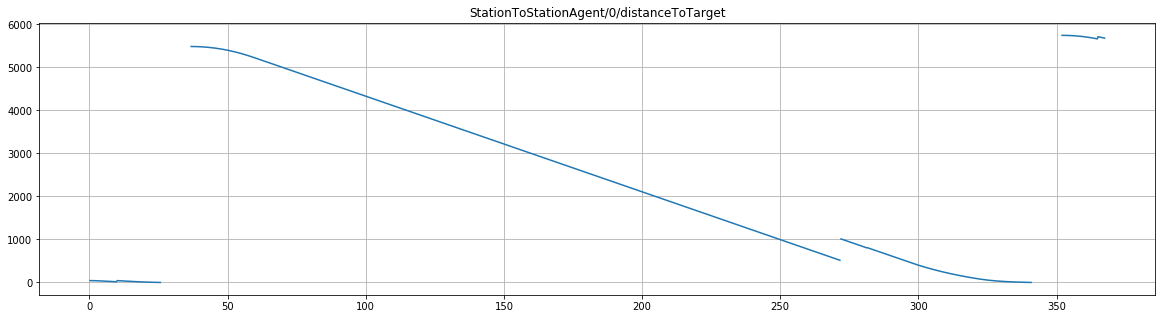

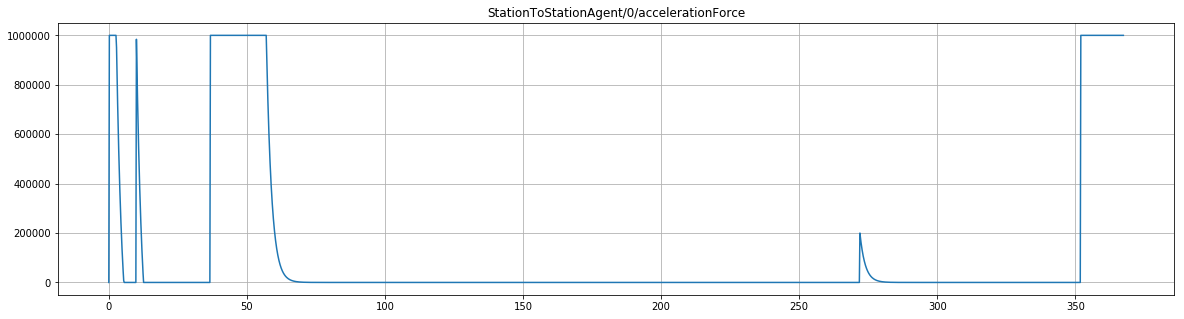

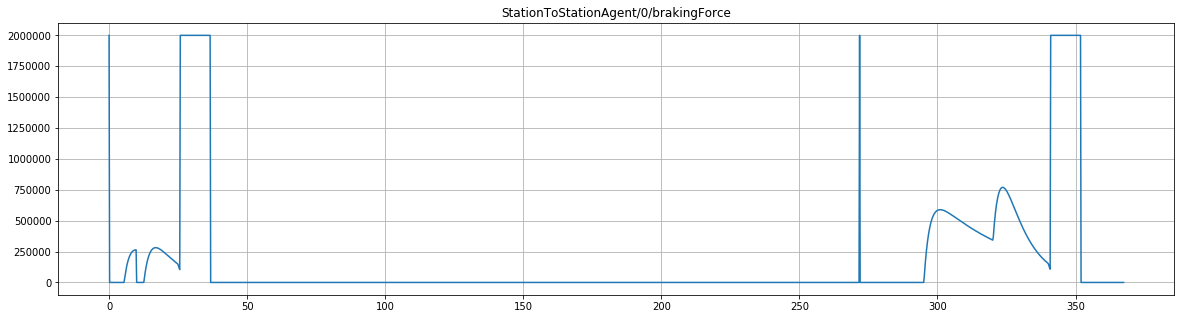

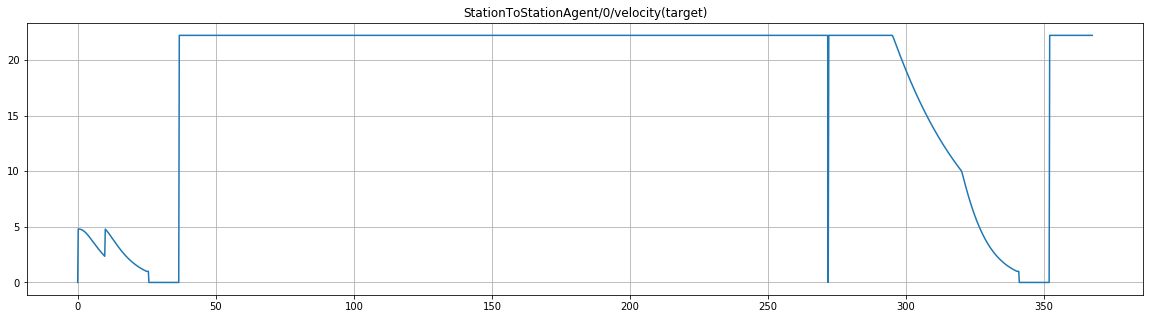

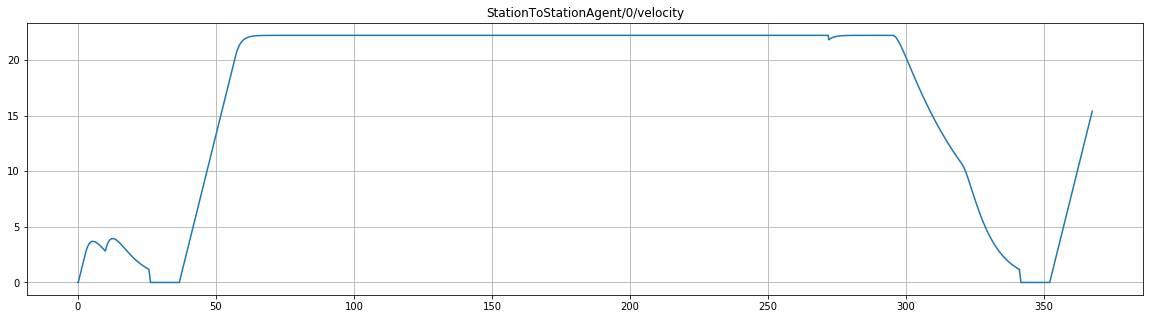

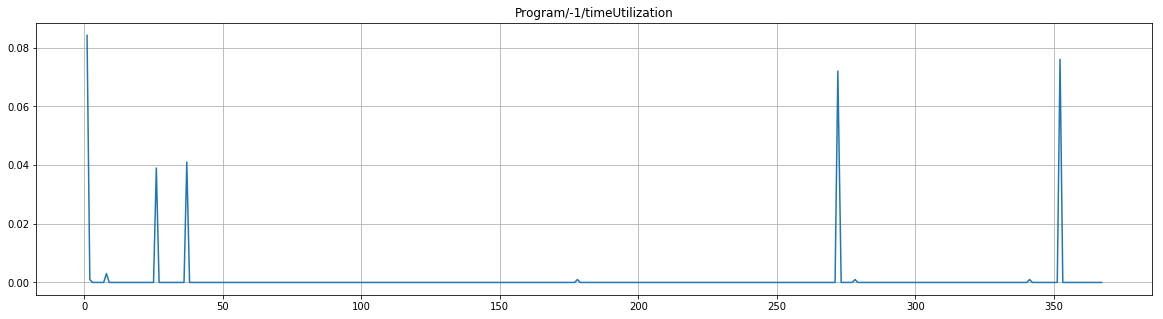

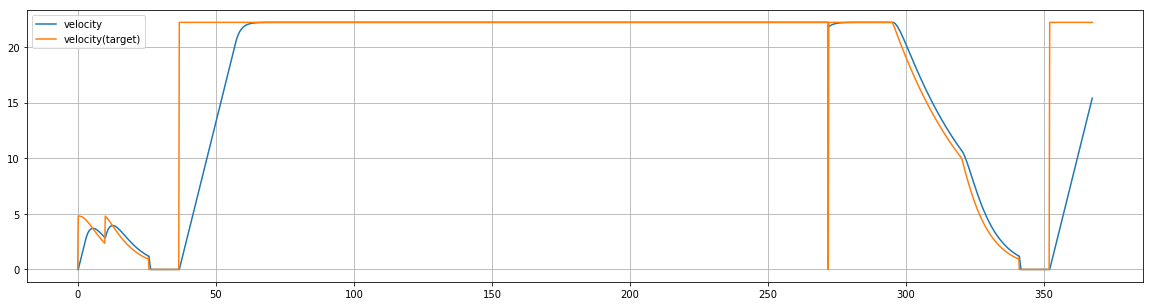

In [30]:
for target_id, this_series in series[str].items():
    print(f'{names[target_id]}:')
    for time, value in zip(*this_series):
        print(f'  {time:7.3f}: {value}')
    print()

xlim = None
#xlim = (0, 12)

display_options_by_pin_name = {
    'debug': dict(display='none'),
    #'segmentId': dict(display='step'),
    'segmentId': dict(display='none'),
}

for target_id, this_series in series[float].items():
    # determine set of display options
    display_options = dict(display='plot')

    tokens = names[target_id].split('/')
    if len(tokens) == 3 and tokens[2] in display_options_by_pin_name:
        display_options = {**display_options, **display_options_by_pin_name[tokens[2]]}

    if display_options['display'] == 'none':
        continue

    # prepare & plot time series
    t, y = this_series[0], this_series[1]

    plt.figure(figsize=(20,5))
    if display_options['display'] == 'plot':
        plt.plot(t, y)
    elif display_options['display'] == 'step':
        # https://stackoverflow.com/a/44961513
        def mystep(x,y, ax=None, **kwargs):
            x = np.array(x)
            y = np.array(y)
            X = np.c_[x[:-1], x[1:], x[1:]]
            Y = np.c_[y[:-1], y[:-1], np.zeros_like(x[:-1]) * np.nan]
            if not ax: ax=plt.gca()
            return ax.plot(X.flatten(), Y.flatten(), **kwargs)

        mystep(t, y)
    plt.grid()
    plt.title(names[target_id])

    if xlim is not None: plt.xlim(*xlim)

reversed_names = dict(map(reversed, names.items()))

plt.figure(figsize=(20,5))
target = reversed_names['StationToStationAgent/0/velocity']
t, y = series[float][target][0], series[float][target][1]
plt.plot(t, y, label='velocity')
target = reversed_names['StationToStationAgent/0/velocity(target)']
t, y = series[float][target][0], series[float][target][1]
plt.plot(t, y, label='velocity(target)')
plt.legend()
plt.grid()